# Discharge Vs Salinity in SoG

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import pickle
import time
import datetime
from scipy.stats import linregress
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import grid_tools
from salishsea_tools import utilities
%matplotlib inline

In [3]:
loadtxt = open('Fraser_flow', 'r')
fraser_discharge = np.loadtxt(loadtxt, usecols =(0,1,2,3), delimiter = ' ')

# Load data from text file into xarray
years, months, days = fraser_discharge[:,0].astype(int), fraser_discharge[:,1].astype(int), fraser_discharge[:,2].astype(int)
discharge_data = fraser_discharge[:,3]

time_array = np.array([])
for date in np.arange(days.shape[0]):
    time_array = np.append(time_array, datetime.datetime(years[date], months[date], days[date]))

data = xr.DataArray(discharge_data, coords = [time_array], dims = ['time'])

In [4]:
salinity = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06")
times_salinity = salinity.time.sel(time = salinity.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

## Function Definitions

In [5]:
def load_data(year, path = "/home/abhudia/Desktop/salinity/Raw/{}salinity.pickle",):
    filename= (path).format(str(year))
    unpickle = open(filename, "rb")
    salinity = pickle.load(unpickle)
    times = []
    for time in times_salinity: 
        if time.year == year:
            times.append(time)
    return(times, salinity)

In [6]:
# gives data and timeseries from discharge data
def give_data_with_time (xarray, year):
    discharge = xarray.loc[xarray['time.year'].isin([year])].values
    times = xarray.loc[xarray['time.year'].isin([year])].time.values.astype('datetime64[D]').astype(datetime.datetime)
    return (times, discharge)

## Scratch space

In [16]:
def average_output(data_array, times, period = 'D'):

    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True) 
    index = 0; count_so_far = 0; means = np.array([])
    
    for count in counts:
        means = np.append(means,sum(data_array[count_so_far: count_so_far + count])/count)
        count_so_far = count_so_far + count
    means = means.reshape(365,540,355)
    return (unique, means)  

In [17]:
for year in [2017,2018]:
    timestart = time.time()
    salinity = load_data(year)
    averaged_grid = average_output(salinity[1], salinity[0])
    salinity = 0
    salinity_xr = xr.DataArray(averaged_grid[1], coords = [averaged_grid[0], range(540), range(355)], dims = ['times', 'gridY', 'gridX'])
    regression_salinity = np.zeros([540,355])
    for i in range(540):
        for j in range(355):
            regression_salinity[i][j] = linregress(give_data_with_time(data, year)[1], salinity_xr.isel(gridY = i, gridX = j).values)[0]
    save = open('regression{}.pickle'.format(str(year)), 'wb')
    pickle.dump(regression_salinity, save)
    save.close()
    print(timestart - time.time())

-569.3508186340332
-516.8081634044647


In [20]:
nemo_mask =xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
contour_mask = nemo_mask.tmaskutil.isel(gridX = slice(10,364), gridY = slice(200,739)).isel(time=0).values

# Regression plots (lighter means higher correlation)

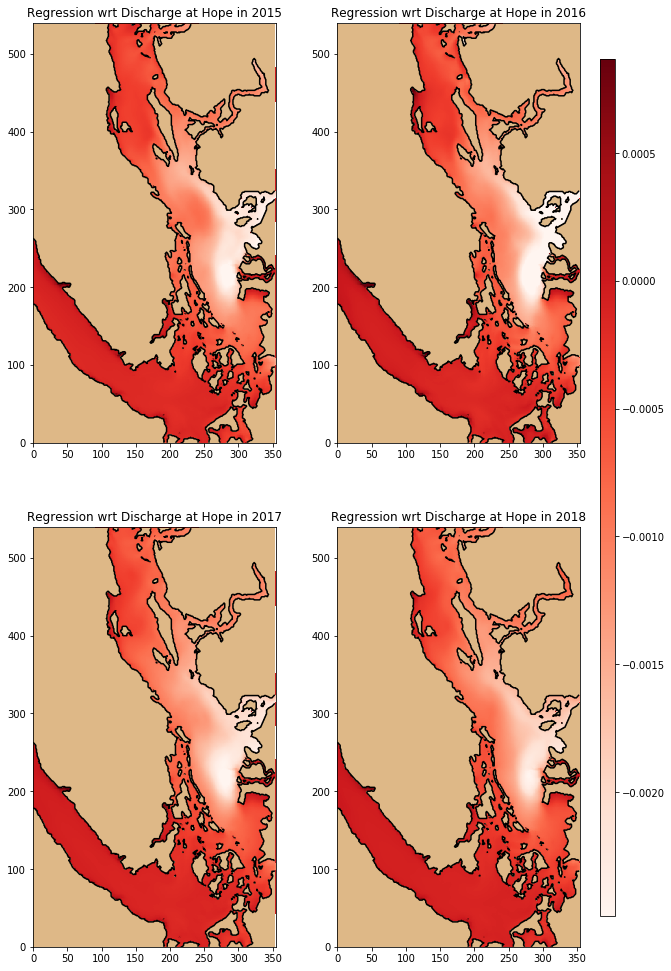

In [41]:
for year in  range(2015,2019):
    all_data = np.array([])
    load = open('regression' + str(year) + '.pickle', 'rb')
    locals()['reg' + str(year)] = pickle.load(load)
    all_data = np.append(all_data, locals()['reg' + str(year)])
    
maxbar = np.nanmax(all_data)
minbar = np.nanmin(all_data)
fig = plt.figure(figsize = (10,17))
colormap = 'Reds'
tick = 1
for year in  range(2015,2019):
    ax = plt.subplot(2,2,tick)
    tick = tick +1
    plt.pcolormesh(locals()['reg' + str(year)], vmin = minbar, vmax = maxbar, cmap = colormap)
    plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
    plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
    viz_tools.set_aspect(ax)
    plt.title('Regression wrt Discharge at Hope in {}'.format(str(year)))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([minbar,maxbar])), cmap = colormap), cax=cbar_ax)